# MOSAiC initial analysis

### Science goals
- Along the possible Mosaic tracks taken from historical data, we want to plot some basic ice state information <br>
- Show the LENS members (30) on each historical track (8) --> 240 iterations
- Show ensemble mean and 1 standard deviation
- Identify when variability arises and begin addressing causes the variability  (correlate arrays of means?)


### Requirements
- Requires netcdf files of the single variable interpolated to each of the ensemble members (30) along each track (8) for each day (365) <br>
- These files were made on burnt using extract_LENS_vars_mosaic_tracks-{ice,atm}.csh with a paired ncl script <br>
- On burnt see: /project/ppc/duvivier/mosaic/analysis/along_track <br>
- The files have been moved to Cheyenne and are minimal in size. See here:/glade/p/cgd/ppc/duvivier/mosaic_along_track_subset/
- Original single variable history files on cheyenne are available for all 30 members for the two year periods starting 1981-01, 2021-01, and 2051-01. These live here: /glade/p/cgd/ppc/duvivier/mosaic/


### Loading in packages and simple xarray manipulations

In [ ]:
#minimal packages needed for this activity
import xarray as xr                          #for slick netCDF operations
import numpy as np                           #for standard numeric manipulation
import matplotlib.pyplot as plt              #standard plotting library based upon Matlab functions
import pickle                                #library for saving and loading Python variables into "pickle" format
from scipy import signal                     #loading frequency analysis part of scientific computing library "scipy"
from scipy import stats                      #loading stats part of scientific computing library "scipy"
from matplotlib.gridspec import GridSpec     #for multipanel plotting

%matplotlib inline

In [2]:
# Manual inputs
yy_st = 2021
ftype = 'ice'
path = '/glade/p/cgd/ppc/duvivier/mosaic/along_track_subset/'+ftype+'/'

# get year strings
yy_ed = yy_st+1
yy_string = str(yy_st)+'0101-'+str(yy_ed)+'1231'

# indicies for labels - relevant to all these plots
label_inds = [17,47,78,109,137,168,198,229,259,290,321,351]
text = ['N','D','J','F','M','A','M','J','J','A','S','O']

years = ['2007','2008','2009','2010','2011','2012','2013','2014']

# Plots and Analysis

## Variable 1 - ice area
Need this so that we can make mask of where to do analysis and not. Main analysis of concentration is in: mosaic_LENS_ice_conc.ipynb

In [3]:
# set variable to read in
var1 = 'aice'
inname = path+'LENS_'+var1+'_mosaic_tracks_'+yy_string+'.nc'
print('Opening file '+inname)
f1 = xr.open_dataset(inname)

Opening file /glade/p/cgd/ppc/duvivier/mosaic/along_track_subset/ice/LENS_aice_mosaic_tracks_20210101-20221231.nc


In [4]:
# Need to make a mask, to use later, of where there are valid values and not
i = 0
j = 0
# replace any concentrations after the value drops below 50% with nans
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        inds = np.where(f1.data_tracks.isel(ensemble=e,year_track=t) < 50.0)
        if len(inds[0]) > 0:
            #print('replacing subsequent values with nans')
            firstindex = inds[0][0]
            #print(firstindex)
            filtered_conc = f1.data_tracks.isel(ensemble=e,year_track=t).values
            filtered_conc[firstindex:] = np.nan
            i = i+1
        else: 
            #print('nope')
            j = j+1

print('tracks that emerged from edge ',i)
print('tracks that stayed in pack ',j)
print('total tracks ',i+j)
            
# Make a mask I can use later with other variables 
mask_in_pack = f1.data_tracks.copy()
mask_in_pack = np.where(mask_in_pack.values > 0.0, 1.0, mask_in_pack.values);

tracks that emerged from edge  99
tracks that stayed in pack  141
total tracks  240


/gpfs/u/apps/ch/opt/python/3.6.4/intel/17.0.1/pkg-library/20180129/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


## Variable 2 - ice thickness

In [6]:
# manual changes
var1 = 'hi'
inname = path+'LENS_'+var1+'_mosaic_tracks_'+yy_string+'.nc'
print('Opening file '+inname)
f1 = xr.open_dataset(inname)

# use mask to get only relevant data (still in pack)
f1['data_tracks_mask'] = mask_in_pack*f1.data_tracks

Opening file /glade/p/cgd/ppc/duvivier/mosaic/along_track_subset/ice/LENS_hi_mosaic_tracks_20210101-20221231.nc


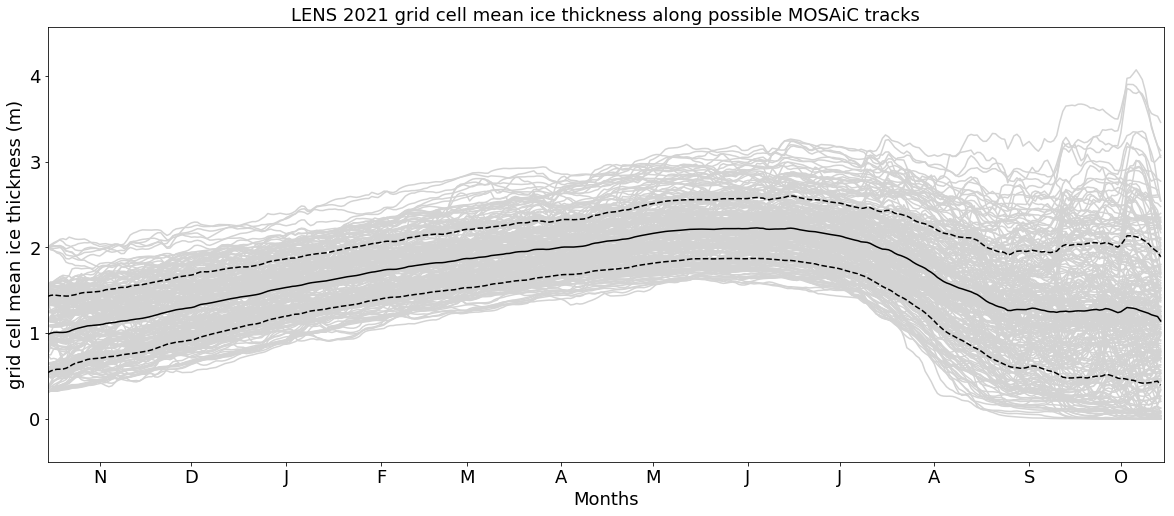

In [9]:
# get metadata
units = f1.data_tracks.units
long_name = f1.data_tracks.long_name

# get basic stats from all ensembles
var_mean = f1.data_tracks_mask.mean(dim=['ensemble','year_track'])
var_stdev = f1.data_tracks_mask.std(dim=['ensemble','year_track'])
bnd_high = var_mean + var_stdev
bnd_low = var_mean - var_stdev
# set limits of standard deviations to be physical (can't be smaller than 0m thick)
bnd_low[bnd_high < 0.0] = 0.0

# plot this
title = 'LENS '+str(yy_st)+' '+str(long_name)+' along possible MOSAiC tracks'

f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks_mask.isel(ensemble=e,year_track=t),color='lightgrey')
plt.plot(np.arange(365),var_mean,color='black')
plt.plot(np.arange(365),bnd_high,color='black',linestyle='dashed')
plt.plot(np.arange(365),bnd_low,color='black',linestyle='dashed')
plt.title(title,size=18)
plt.xlabel('Months',size=18)
plt.ylabel(long_name+' ('+units+')',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim([np.min(f1.data_tracks)-0.5,np.max(f1.data_tracks)+0.5])
plt.xlim(0,365);

In [24]:
# look at mean thickness at start and end
diff = var_mean.values[364] - var_mean.values[0]
print('final minus original mean thickness: ', diff)
print('maximum mean thickness: ',np.amax(var_mean))
#print('maximum thickness for an ensemble member: ', np.amax(f1.data_tracks_mask.mean))

final minus original mean thickness:  0.15727004595308414
maximum mean thickness:  <xarray.DataArray 'data_tracks_mask' ()>
array(2.227006)


In [35]:
print(mask_in_pack.shape)
print(mask_in_pack[1,8,:])

(8, 30, 365)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

In [22]:
print(f1.data_tracks_mask.isel(ensemble=28,year_track=1).values)
print(mask_in_pack)

[1.40788388 1.41856992 1.42623734 1.42374039 1.4222703  1.41995227
 1.41980994 1.4380461  1.47428823 1.48669517 1.50357389 1.54888868
 1.54204583 1.48251832 1.44797707 1.4527874  1.45976162 1.49338508
 1.55043149 1.6259439  1.63871729 1.64146566 1.6513865  1.6574204
 1.65036011 1.64744925 1.65794957 1.65958095 1.66494536 1.67400706
 1.67198265 1.70022464 1.744313   1.75295663 1.75117862 1.77327776
 1.77784038 1.77704954 1.78649974 1.80102193 1.80634201 1.79962647
 1.79067576 1.78230178 1.77601492 1.77084315 1.77666867 1.78395641
 1.80356777 1.83898437 1.85639977 1.84152162 1.83266652 1.8293165
 1.81478584 1.78522038 1.76663148 1.76464701 1.75360477 1.73340058
 1.72946286 1.73633313 1.73096061 1.74163413 1.73045135 1.70947087
 1.70241475 1.72538424 1.75595295 1.77507448 1.81768441 1.86298716
 1.91499007 1.94674897 1.95509434 1.94306564 1.90709031 1.89138734
 1.92133892 1.94644892 1.95499408 1.9444176  1.96978951 1.95609474
 1.96160448 1.96478033 1.97081101 1.98615634 1.99097252 1.966395

The ice starts with a mean around 1m with a stdev of 0.5m. One ensemble has consistently thicker ice (2m) throughout (top 8 lines for the 8 tracks). Growth occurs until about June, then decreases. There are thicknesses up to 3 m or more in some ensembles, though the mean has a maximum of ~2m. Want to understand growth through the winter too (mass budget). 

## Variable 3 - Snow fraction

In [ ]:
# manual changes
var1 = 'fs'
inname = path+'LENS_'+var1+'_mosaic_tracks_'+yy_string+'.nc'
print('Opening file '+inname)
f1 = xr.open_dataset(inname)

In [ ]:
# get metadata
units = f1.data_tracks.units
long_name = f1.data_tracks.long_name
# indicies for labels
label_inds = [17,47,78,109,137,168,198,229,259,290,321,351]
text = ['N','D','J','F','M','A','M','J','J','A','S','O']

# Convert all to % by multiplying by 100
# get basic stats from all ensembles
var_mean = f1.data_tracks.mean(dim=['ensemble','year_track'])*100.0
var_stdev = f1.data_tracks.std(dim=['ensemble','year_track'])*100.0

# plot this
title = 'LENS '+str(yy_st)+' '+str(long_name)+' along possible MOSAiC tracks'

f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t)*100.0,color='lightgrey')
plt.plot(np.arange(365),var_mean,color='black')
plt.plot(np.arange(365),var_mean+var_stdev,color='black',linestyle='dashed')
plt.plot(np.arange(365),var_mean-var_stdev,color='black',linestyle='dashed')
plt.title(title,size=18)
plt.xlabel('Months',size=18)
plt.ylabel(long_name+'(%)',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim(0,101)
plt.xlim(0,365);

## Variable 4 - Snow thickness

In [ ]:
# manual changes
var1 = 'hs'
inname = path+'LENS_'+var1+'_mosaic_tracks_'+yy_string+'.nc'
print('Opening file '+inname)
f1 = xr.open_dataset(inname)

In [ ]:
# get metadata
units = f1.data_tracks.units
long_name = f1.data_tracks.long_name
# indicies for labels
label_inds = [17,47,78,109,137,168,198,229,259,290,321,351]
text = ['N','D','J','F','M','A','M','J','J','A','S','O']

# Convert all to % by multiplying by 100
# get basic stats from all ensembles
var_mean = f1.data_tracks.mean(dim=['ensemble','year_track'])*100.0
var_stdev = f1.data_tracks.std(dim=['ensemble','year_track'])*100.0

# plot this
title = 'LENS '+str(yy_st)+' '+str(long_name)+' along possible MOSAiC tracks'

f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t),color='lightgrey')
plt.plot(np.arange(365),var_mean,color='black')
plt.plot(np.arange(365),var_mean+var_stdev,color='black',linestyle='dashed')
plt.plot(np.arange(365),var_mean-var_stdev,color='black',linestyle='dashed')
plt.title(title,size=18)
plt.xlabel('Months',size=18)
plt.ylabel(long_name+' ('+units+')',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
#plt.ylim(0,101)
plt.xlim(0,365);

In [ ]:
f1.data_tracks.isel(ensemble=0,year_track=0).values

## Variable 5 - FYarea

In [ ]:
# manual changes
var1 = 'FYarea'
inname = path+'LENS_'+var1+'_mosaic_tracks_'+yy_string+'.nc'
print('Opening file '+inname)
f1 = xr.open_dataset(inname)

In [ ]:
# get metadata
units = f1.data_tracks.units
long_name = f1.data_tracks.long_name
# indicies for labels
label_inds = [17,47,78,109,137,168,198,229,259,290,321,351]
text = ['N','D','J','F','M','A','M','J','J','A','S','O']

# Convert all to % by multiplying by 100
# get basic stats from all ensembles
var_mean = f1.data_tracks.mean(dim=['ensemble','year_track'])*100.0
var_stdev = f1.data_tracks.std(dim=['ensemble','year_track'])*100.0

# plot this
title = 'LENS '+str(yy_st)+' '+str(long_name)+' along possible MOSAiC tracks'

f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t)*100.0,color='lightgrey')
plt.plot(np.arange(365),var_mean,color='black')
plt.plot(np.arange(365),var_mean+var_stdev,color='black',linestyle='dashed')
plt.plot(np.arange(365),var_mean-var_stdev,color='black',linestyle='dashed')
plt.title(title,size=18)
plt.xlabel('Months',size=18)
plt.ylabel(long_name+'(%)',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim(0,101)
plt.xlim(0,365);

## Variable 6 - melt onset

In [ ]:
# manual changes
var1 = 'mlt_onset'
inname = path+'LENS_'+var1+'_mosaic_tracks_'+yy_string+'.nc'
print('Opening file '+inname)
f1 = xr.open_dataset(inname)

In [ ]:
# get metadata
units = f1.data_tracks.units
long_name = f1.data_tracks.long_name
# indicies for labels
label_inds = [17,47,78,109,137,168,198,229,259,290,321,351]
text = ['N','D','J','F','M','A','M','J','J','A','S','O']

# Convert all to % by multiplying by 100
# get basic stats from all ensembles
var_mean = f1.data_tracks.mean(dim=['ensemble','year_track'])*100.0
var_stdev = f1.data_tracks.std(dim=['ensemble','year_track'])*100.0

# plot this
title = 'LENS '+str(yy_st)+' '+str(long_name)+' along possible MOSAiC tracks'

f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t)*100.0,color='lightgrey')
plt.plot(np.arange(365),var_mean,color='black')
plt.plot(np.arange(365),var_mean+var_stdev,color='black',linestyle='dashed')
plt.plot(np.arange(365),var_mean-var_stdev,color='black',linestyle='dashed')
plt.title(title,size=18)
plt.xlabel('Months',size=18)
plt.ylabel(long_name+'(%)',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim(0,101)
plt.xlim(0,365);

## Variable 7 - melt pond area

In [ ]:
# manual changes
var1 = 'apond'
inname = path+'LENS_'+var1+'_mosaic_tracks_'+yy_string+'.nc'
print('Opening file '+inname)
f1 = xr.open_dataset(inname)

In [ ]:
# get metadata
units = f1.data_tracks.units
long_name = f1.data_tracks.long_name
# indicies for labels
label_inds = [17,47,78,109,137,168,198,229,259,290,321,351]
text = ['N','D','J','F','M','A','M','J','J','A','S','O']

# Convert all to % by multiplying by 100
# get basic stats from all ensembles
var_mean = f1.data_tracks.mean(dim=['ensemble','year_track'])*100.0
var_stdev = f1.data_tracks.std(dim=['ensemble','year_track'])*100.0

# plot this
title = 'LENS '+str(yy_st)+' '+str(long_name)+' along possible MOSAiC tracks'

f=plt.figure(figsize=(20,8))
for e in np.arange(f1.ensemble.size):
    for t in np.arange(f1.year_track.size):
        plt.plot(np.arange(365),f1.data_tracks.isel(ensemble=e,year_track=t)*100.0,color='lightgrey')
plt.plot(np.arange(365),var_mean,color='black')
plt.plot(np.arange(365),var_mean+var_stdev,color='black',linestyle='dashed')
plt.plot(np.arange(365),var_mean-var_stdev,color='black',linestyle='dashed')
plt.title(title,size=18)
plt.xlabel('Months',size=18)
plt.ylabel(long_name+'(%)',size=18)
plt.xticks(label_inds,text,size=18)
plt.yticks(size=18)
plt.ylim(0,101)
plt.xlim(0,365);

In [ ]:
# other order 1 variables. Also look by category (aicen001-005 and apond001-005). Also look into atmosphere variables (wind speed, wind dir, IWP, LWP, etc.)